# Instalando extensão Verilog

In [80]:
!pip install graphviz
!pip install git+git://github.com/lesc-ufv/cad4u.git
!git clone https://github.com/lesc-ufv/cad4u
%load_ext plugin

  Cloning git://github.com/lesc-ufv/cad4u.git to /tmp/pip-req-build-05a_djlo
  Running command git clone -q git://github.com/lesc-ufv/cad4u.git /tmp/pip-req-build-05a_djlo
fatal: destination path 'cad4u' already exists and is not an empty directory.
The plugin extension is already loaded. To reload it, use:
  %reload_ext plugin


# Instalando riscV-assembler

In [81]:
!pip install riscv-assembler

# Montador RiscV
Executando códigos para ser reaproveitados abaixo

In [82]:
%%writefile simple.s
add x1,x1,x1

Overwriting simple.s


In [83]:
from riscv_assembler.convert import AssemblyConverter
!rm -f -r simple/*
def assemble():
  cnv = AssemblyConverter(output_type = "t") #just text
  cnv.convert("simple.s")
  # Using readlines()
  file1 = open('simple/txt/simple.txt', 'r')
  Lines = file1.readlines()
  file1 = open('im_data.txt', 'w')


  for line in Lines:
    decimal_representation = int(line, 2)
    hexadecimal_string = hex(decimal_representation)
    file1.write(hexadecimal_string[2:]+'\n')

  file1.close()

# Risc-V

# Arquivos de registradores

In [84]:
%%writefile rm_data.txt
0
01
02
03
04
05
06
07
08
09
0A
0B
0C
0D
0E
0F
10
11
12
13

Overwriting rm_data.txt


## Memória de dados

In [85]:
%%writefile dm_data.txt
0
1
2
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19

Overwriting dm_data.txt


## Memória de instruções

#### Exemplo de programa

In [86]:
%%writefile simple.s
add x1,x2,x3
add x4,x5,x6
add x7,x8,x9
sub x10,x11,x12
add x1,x1,x1

Overwriting simple.s


In [87]:
from riscv_assembler.convert import AssemblyConverter
!rm -f -r simple/*
cnv = AssemblyConverter(output_type = "t") #just text
cnv.convert("simple.s")
# Using readlines()
file1 = open('simple/txt/simple.txt', 'r')
Lines = file1.readlines()
file1 = open('im_data.txt', 'w')


for line in Lines:
   decimal_representation = int(line, 2)
   hexadecimal_string = hex(decimal_representation)
   file1.write(hexadecimal_string[2:]+'\n')

file1.close()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 5


In [88]:
!cat simple/txt/simple.txt

00000000001100010000000010110011
00000000011000101000001000110011
00000000100101000000001110110011
01000000110001011000010100110011
00000000000100001000000010110011


In [89]:
!cat im_data.txt

3100b3
628233
9403b3
40c58533
1080b3


### Ou digite suas instruções RiscV diretamente, em modo hexadecimal

In [90]:
%%writefile im_data.txt
20090001
01294820
01e9502a
1140fffd
2129ffff
2129ffff
2129ffff

Overwriting im_data.txt


# Código dos 5 estágios do RiscV

## Arquivo verilog registrador genérico

In [91]:
%%writefile regr.v
module regr (	input clk,input clear,input hold,
	input wire [N-1:0] in,
	output reg [N-1:0] out);

	parameter N = 1;

	always @(posedge clk) begin
		if (clear)
			out <= {N{1'b0}};
		else if (hold)
			out <= out;
		else
			out <= in;
	end
endmodule


Overwriting regr.v


## Arquivo verilog de registrador e memória de instruções

In [92]:
%%writefile im_reg.v
module im(input wire			clk,input wire 	[31:0] 	addr,output wire [31:0] 	data);
	parameter NMEM = 128;   // Number of memory entries,
							// not the same as the memory size
	parameter IM_DATA = "im_data.txt";  // file to read data from
	reg [31:0] mem [0:127];  // 32-bit memory with 128 entries
	initial begin
		$readmemh(IM_DATA, mem, 0, NMEM-1);
	end
	assign data = mem[addr[8:2]][31:0];
endmodule

module regm(		input wire			clk,input wire  [4:0]	read1, read2,
		output wire [31:0]	data1, data2,input wire			regwrite, input wire	[4:0]	wrreg,input wire	[31:0]	wrdata);

	parameter NMEM = 20;   // Number of memory entries,
							// not the same as the memory size
	parameter RM_DATA = "rm_data.txt";  // file to read data from

	reg [31:0] mem [0:31];  // 32-bit memory with 32 entries

	initial begin
		$readmemh(RM_DATA, mem, 0, NMEM-1);
	end
	reg [31:0] _data1, _data2;
	always @(*) begin
		if (read1 == 5'd0)
			_data1 = 32'd0;
		else if ((read1 == wrreg) && regwrite)
			_data1 = wrdata;
		else
			_data1 = mem[read1][31:0];
	end

	always @(*) begin
		if (read2 == 5'd0)
			_data2 = 32'd0;
		else if ((read2 == wrreg) && regwrite)
			_data2 = wrdata;
		else
			_data2 = mem[read2][31:0];
	end

	assign data1 = _data1;
	assign data2 = _data2;

	always @(posedge clk) begin
		if (regwrite && wrreg != 5'd0) begin
			// write a non $zero register
			mem[wrreg] <= wrdata;
		end
	end
endmodule


Overwriting im_reg.v


## Arquivo verilog memória de dados

In [93]:
%%writefile datam.v
module dm(
		input wire			clk,
		input wire	[6:0]	addr,
		input wire			rd, wr,
		input wire 	[31:0]	wdata,
		output wire	[31:0]	rdata);
	parameter NMEM = 20;   // Number of memory entries,
							// not the same as the memory size
	parameter RM_DATA = "dm_data.txt";  // file to read data from

	reg [31:0] mem [0:127];  // 32-bit memory with 128 entries

        initial begin
		$readmemh(RM_DATA, mem, 0, NMEM-1);
	end
		

	always @(posedge clk) begin
		if (wr) begin
			mem[addr] <= wdata;
		end
	end

	assign rdata = wr ? wdata : mem[addr];
	// During a write, avoid the one cycle delay by reading from 'wdata'

endmodule




Overwriting datam.v


## Alu e controle da Alu

In [94]:
%%writefile alu.v
module alu_control(
		input wire [3:0] funct,
		input wire [1:0] aluop,
		output reg [3:0] aluctl);

	reg [3:0] _funct;

	always @(*) begin
		case(funct[3:0])
			4'd0:  _funct = 4'd2;	/* add */
			4'd8:  _funct = 4'd6;	/* sub */
			4'd6:  _funct = 4'd1;	/* or */
			4'bx110: _funct = 4'd1; /* ori modificado, onde o bit da posição 3 é um dont care */
			4'd4:  _funct = 4'd13;	/* xor */
			4'd7:  _funct = 4'd12;	/* nor */
			4'd2: _funct = 4'd7;	/* slt */
			4'd1: _funct = 4'd8;    /* SLLI: o valor do funct para o SLLI é 1, pois seu funct3 é 001 e seu funct7 é 0000000 */
			

			default: _funct = 4'd0;
		endcase
	end


	always @(*) begin
		case(aluop)
			2'd0: aluctl = 4'd2;	/* add */
			2'd1: begin     /*opcode de instruções branch*/       
			if(funct[2:0] == 3'b100)
              aluctl = 4'd7; /* se for BLT, informa a ALU que ela deverá realizar a operação de menor que(códificada pelo número 8 em binário) */
			else 
			  aluctl = 4'd6; /* se for BEQ, passa para a ALU a operação de subtração */
			end
			2'd2: aluctl = _funct;
			2'd3: aluctl = 4'd2;	/* add */
			default: aluctl = 0;
		endcase
	end	

endmodule


module alu(
		input		[3:0]	ctl,
		input		[31:0]	a, b,
		output reg	[31:0]	out,
		output				zero);

	wire [31:0] sub_ab;
	wire [31:0] add_ab;
	wire 		oflow_add;
	wire 		oflow_sub;
	wire 		oflow;
	wire 		slt;


	assign sub_ab = a - b; 
	assign add_ab = a + b;
	assign oflow_add = (a[31] == b[31] && add_ab[31] != a[31]) ? 1 : 0;
	assign oflow_sub = (a[31] == b[31] && sub_ab[31] != a[31]) ? 1 : 0;
	assign oflow = (ctl == 4'b0010) ? oflow_add : oflow_sub;
	// set if less than, 2s compliment 32-bit numbers
	assign slt = oflow_sub ? ~(a[31]) : a[31];
	always @(*) begin
		case (ctl)
			4'd2:  out <= add_ab;				/* add */
			4'd0:  out <= a & b;				/* and */
			4'd12: out <= ~(a | b);				/* nor */
			4'd1:  out <= a | b;				/* or */
			4'd7:  out <= {{31{1'b0}}, slt};	/* slt */
			4'd6:  out <= sub_ab;				/* sub */
			4'd13: out <= a ^ b;				/* xor */
			4'd8:  out <= a << b;               /* SLL */
			default: out <= 0;
		endcase
	end
	assign zero = (out == 32'b0) ? 1'b1 : 1'b0; // checa se o out é igual a zero, caso positivo muda o sinal da variável zero para um.

endmodule


Overwriting alu.v


## Unidade de controle

In [95]:
%%writefile control.v
module control(
		input  wire	[6:0]	opcode,
		output reg			branch_eq, branch_ne, branch_lt,
		output reg [1:0]	aluop,
		output reg			memread, memwrite, memtoreg,
		output reg			regdst, regwrite, alusrc,
		output reg			jump,
    output reg [31:0] ImmGen,
    input [31:0] inst);
    wire[2:0] f3 = inst[14:12]; //funct3 para diferenciar as instruções de branch
	always @(*) begin
		/* defaults */
		aluop[1:0]	<= 2'b10;
		alusrc		<= 1'b0;
		branch_eq	<= 1'b0;
		branch_ne	<= 1'b0;
		branch_lt   <= 1'b0; //Adicionamos a inicialização default para o BLT
		memread		<= 1'b0;
		memtoreg	<= 1'b0;
		memwrite	<= 1'b0;
		regdst		<= 1'b1;
		regwrite	<= 1'b1;
		jump		<= 1'b0;

		case (opcode)
     7'b0000011: begin // lw == 3
        	alusrc   <= 1'b1;
          aluop[1:0]	<= 2'b00;
        	memtoreg <= 1'b1;                 
        	regwrite <= 1'b1;    
        	memread  <= 1'b1;
        	ImmGen   <= {{20{inst[31]}},inst[31:20]};
      	end
			7'b0010011: begin	/* addi */
				//regdst   <= 1'b0; // rt or rd (only mips)
				aluop <= 2'b10;
				alusrc   <= 1'b1;
        ImmGen   <= {{20{inst[31]}},inst[31:20]};
			end
      7'b1100011: begin // beq == 99
          aluop  <= 2'b01;
    	    ImmGen   <= {{19{inst[31]}},inst[31],inst[7],inst[30:25],inst[11:8],1'b0}; 
          regwrite  <= 1'b0;
          branch_eq <= (f3 == 3'b000) ? 1'b1 : 1'b0; 
          branch_ne <= (f3 == 3'b001) ? 1'b1 : 1'b0;
          branch_lt <= (f3 == 3'b100) ? 1'b1 : 1'b0;


		  end
			7'b0100011: begin	/* sw */
				memwrite <= 1'b1;
				aluop[1] <= 1'b0;
				alusrc   <= 1'b1;
				regwrite <= 1'b0;
        ImmGen   <= {{20{inst[31]}},inst[31:25],inst[11:7]};
			end
			7'b0110011: begin	/* add */
			end
			6'b000010: begin	/* j jump */
				jump <= 1'b1;
			end
		endcase
	end
endmodule

Overwriting control.v


<img src="https://raw.githubusercontent.com/cacauvicosa/mips/master/michael/riscv/riscv-single/riscv-single.png" width="600">

## Processador RISCV


### RiscV Opcodes bits e Registradores


<img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/mips_opcode_regs.png" alt="wscad2020" width="300"/>  <img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/riscV_opcode_regs.png" alt="wscad2020" width="300"/> 

### Código de decodificação

In [96]:
%%writefile decodefields.v
wire [5:0]  opcode; wire [6:0]  opcoderv; 
	wire [4:0]  rs;     wire [4:0]  rs1;
	wire [4:0]  rt;     wire [4:0]  rs2;
	wire [4:0]  rd;
                      wire [6:0] func7; wire [2:0] func3;
	wire [15:0] imm;
	wire [4:0]  shamt;
	wire [31:0] jaddr_s2;
	wire [31:0] seimm;  // sign extended immediate
	//
	assign opcode   = inst_s2[31:26];  assign opcoderv   = inst_s2[6:0]; 
	assign rs       = inst_s2[25:21];  assign rs2       = inst_s2[24:20];
	assign rt       = inst_s2[20:16];  assign rs1       = inst_s2[19:15];
	assign rd       = inst_s2[11:7];
                                      assign func7       = inst_s2[31:25];
                                      assign func3       = inst_s2[14:12];
	assign imm      = inst_s2[15:0];
	assign shamt    = inst_s2[10:6];
	assign jaddr_s2 = {pc[31:28], inst_s2[25:0], {2{1'b0}}};
	assign seimm 	= {{16{inst_s2[15]}}, inst_s2[15:0]};

  // register file
	wire [31:0] data1, data2;
	regm regm1(.clk(clk), .read1(rs1), .read2(rs2),
			.data1(data1), .data2(data2),
			.regwrite(regwrite_s5), .wrreg(wrreg_s5),
			.wrdata(wrdata_s5));

      // control (opcode -> ...)
	wire		regdst;
	wire		branch_eq_s2;
	wire		branch_ne_s2;
  wire		branch_lt_s2;
	wire		memread;
	wire		memwrite;
	wire		memtoreg;
	wire [1:0]	aluop;
	wire		regwrite;
	wire		alusrc;
	wire		jump_s2;
  wire [31:0] ImmGen;  // RISCV
	//
  //agora passa blt para o control
	control ctl1(.opcode(opcoderv), .regdst(regdst),
				.branch_eq(branch_eq_s2), .branch_ne(branch_ne_s2), .branch_lt(branch_lt_s2),
				.memread(memread),
				.memtoreg(memtoreg), .aluop(aluop),
				.memwrite(memwrite), .alusrc(alusrc),
				.regwrite(regwrite), .jump(jump_s2), .ImmGen(ImmGen), .inst(inst_s2));

  	// pass rs to stage 3 (for forwarding)
	wire [4:0] rs_s3;     	wire [4:0] rs1_s3;
	regr #(.N(5)) regr_s2_rs(.clk(clk), .clear(1'b0), .hold(stall_s1_s2),
				.in(rs1), .out(rs1_s3));

	// transfer seimm, rt, and rd to stage 3
	wire [31:0] seimm_s3;
	wire [4:0] 	rt_s3;    wire [4:0] rs2_s3;
	wire [4:0] 	rd_s3;
	regr #(.N(32)) reg_s2_seimm(.clk(clk), .clear(flush_s2), .hold(stall_s1_s2),
						.in(ImmGen), .out(seimm_s3));  // RISCV
	regr #(.N(10)) reg_s2_rt_rd(.clk(clk), .clear(flush_s2), .hold(stall_s1_s2),
						.in({rs2, rd}), .out({rs2_s3, rd_s3}));

  // shift left, seimm
	wire [31:0] seimm_sl2;
	assign seimm_sl2 = {seimm[29:0], 2'b0};  // shift left 2 bits
	// branch address
	wire [31:0] baddr_s2;
	assign baddr_s2 = pc4_s2 + ImmGen;

  wire [3:0] func_s3;
  
  	regr #(.N(4)) func7_3_s2(.clk(clk), .clear(1'b0), .hold(stall_s1_s2), 
						.in({func7[5],func3}), .out(func_s3));




Overwriting decodefields.v


### RiscV Immediate and Funct Alucontrol

<img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/mips_imgen_aluctrl.png" alt="wscad2020" width="300"/>  <img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/imgen_aluctrl_RiscV.png" alt="wscad2020" width="300"/> 

### Estágio de execução

In [97]:
%%writefile execution_newcode.v
// ALU
	// second ALU input can come from an immediate value or data
	wire [31:0] alusrc_data2;
	assign alusrc_data2 = (alusrc_s3) ? seimm_s3 : fw_data2_s3;
	// ALU control
	wire [3:0] aluctl;
	wire [5:0] funct;
	assign funct = seimm_s3[5:0];
	alu_control alu_ctl1(.funct(func_s3), .aluop(aluop_s3), .aluctl(aluctl));
	// ALU
	wire [31:0]	alurslt;
  wire zero_s3;
	alu alu1(.ctl(aluctl), .a(fw_data1_s3), .b(alusrc_data2), .out(alurslt),
									.zero(zero_s3));

                  	// write register
	wire [4:0]	wrreg;
	wire [4:0]	wrreg_s4;
	assign wrreg = (regdst_s3) ? rd_s3 : rs2_s3;


Overwriting execution_newcode.v


### Mips e RISCV Formato de instruções

<img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/mips_formato_instrucoes.png" alt="wscad2020" width="500"/>  <img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/riscVaddsubaddildsd.png" alt="wscad2020" width="500"/> 

### DATAPATH

<img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/riscvhazard_forward.png" alt="wscad2020" width="800"/> 


### Código main

In [98]:
%%writefile main.v
/*
 * cpu. - five stage MIPS CPU.
 *
 */


`include "regr.v"
`include "im_reg.v"
`include "alu.v"
`include "control.v"
`include "datam.v"



module cpu(
		input wire clk);

	parameter NMEM = 7;  // number in instruction memory
	parameter IM_DATA = "im_data.txt";

	wire regwrite_s5;
	wire [4:0] wrreg_s5;
	wire [31:0]	wrdata_s5;
	reg stall_s1_s2;

	// {{{ flush control
	reg flush_s1, flush_s2, flush_s3;
	always @(*) begin
		flush_s1 <= 1'b0;
		flush_s2 <= 1'b0;
		flush_s3 <= 1'b0;
		if (pcsrc | jump_s4) begin
			flush_s1 <= 1'b1;
			flush_s2 <= 1'b1;
			flush_s3 <= 1'b1;
		end
	end
	// }}}

	// {{{ stage 1, IF (fetch)

	reg  [5:0] clock_counter;
	initial begin
		clock_counter <= 6'd1;
	end
        always @(posedge clk) begin
                clock_counter <= clock_counter + 1;
	end

	reg  [31:0] pc;
	initial begin
		pc <= 32'd0;
	end

	wire [31:0] pc4;  // PC + 4
	assign pc4 = pc + 4;   

	always @(posedge clk) begin
		if (stall_s1_s2) 
			pc <= pc;
		else if (pcsrc == 1'b1)
			pc <= baddr_s4;
		else if (jump_s4 == 1'b1)
			pc <= jaddr_s4;
		else
			pc <= pc4;
	end

	// pass PC + 4 to stage 2
	wire [31:0] pc4_s2;
	regr #(.N(32)) regr_pc4_s2(.clk(clk),
						.hold(stall_s1_s2), .clear(flush_s1),
						.in(pc), .out(pc4_s2));

	// instruction memory
	wire [31:0] inst;
	wire [31:0] inst_s2;
	im #(.NMEM(NMEM), .IM_DATA(IM_DATA))
		im1(.clk(clk), .addr(pc), .data(inst));
	regr #(.N(32)) regr_im_s2(.clk(clk),
						.hold(stall_s1_s2), .clear(flush_s1),
						.in(inst), .out(inst_s2));

	// }}}

	// {{{ stage 2, ID (decode)

`include "decodefields.v"


	// transfer register data to stage 3
	wire [31:0]	data1_s3, data2_s3;
	regr #(.N(64)) reg_s2_mem(.clk(clk), .clear(flush_s2), .hold(stall_s1_s2),
				.in({data1, data2}),
				.out({data1_s3, data2_s3}));


	// transfer PC + 4 to stage 3
	wire [31:0] pc4_s3;
	regr #(.N(32)) reg_pc4_s2(.clk(clk), .clear(1'b0), .hold(stall_s1_s2),
						.in(pc4_s2), .out(pc4_s3));

	


	// transfer the control signals to stage 3
	wire		regdst_s3;
	wire		memread_s3;
	wire		memwrite_s3;
	wire		memtoreg_s3;
	wire [1:0]	aluop_s3;
	wire		regwrite_s3;
	wire		alusrc_s3;
	// A bubble is inserted by setting all the control signals
	// to zero (stall_s1_s2).
	regr #(.N(8)) reg_s2_control(.clk(clk), .clear(stall_s1_s2), .hold(1'b0),
			.in({regdst, memread, memwrite,
					memtoreg, aluop, regwrite, alusrc}),
			.out({regdst_s3, memread_s3, memwrite_s3,
					memtoreg_s3, aluop_s3, regwrite_s3, alusrc_s3}));

	wire branch_eq_s3, branch_ne_s3, branch_lt_s3;
	regr #(.N(3)) branch_s2_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
				.in({branch_eq_s2, branch_ne_s2,branch_lt_s2}),
				.out({branch_eq_s3, branch_ne_s3,branch_lt_s3}));

	wire [31:0] baddr_s3;
	regr #(.N(32)) baddr_s2_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
				.in(baddr_s2), .out(baddr_s3));

	wire jump_s3;
	regr #(.N(1)) reg_jump_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
				.in(jump_s2),
				.out(jump_s3));

	wire [31:0] jaddr_s3;
	regr #(.N(32)) reg_jaddr_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
				.in(jaddr_s2), .out(jaddr_s3));
	// }}}

	// {{{ stage 3, EX (execute)

	reg [31:0] fw_data1_s3;
`include "execution_newcode.v"

	// pass through some control signals to stage 4
	wire regwrite_s4;
	wire memtoreg_s4;
	wire memread_s4;
	wire memwrite_s4;
	regr #(.N(4)) reg_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
				.in({regwrite_s3, memtoreg_s3, memread_s3,
						memwrite_s3}),
				.out({regwrite_s4, memtoreg_s4, memread_s4,
						memwrite_s4}));


	always @(*)
	case (forward_a)
			2'd1: fw_data1_s3 = alurslt_s4;
			2'd2: fw_data1_s3 = wrdata_s5;
		 default: fw_data1_s3 = data1_s3;
	endcase

	wire zero_s4;
	regr #(.N(1)) reg_zero_s3_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
					.in(zero_s3), .out(zero_s4));

	// pass ALU result and zero to stage 4
	wire [31:0]	alurslt_s4;
	regr #(.N(32)) reg_alurslt(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in({alurslt}),
				.out({alurslt_s4}));

	// pass data2 to stage 4
	wire [31:0] data2_s4;
	reg [31:0] fw_data2_s3;
	always @(*)
	case (forward_b)
			2'd1: fw_data2_s3 = alurslt_s4;
			2'd2: fw_data2_s3 = wrdata_s5;
		 default: fw_data2_s3 = data2_s3;
	endcase
	regr #(.N(32)) reg_data2_s3(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in(fw_data2_s3), .out(data2_s4));


	// pass to stage 4
	regr #(.N(5)) reg_wrreg(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in(wrreg), .out(wrreg_s4));

	wire branch_eq_s4, branch_ne_s4, branch_lt_s4;
	regr #(.N(3)) branch_s3_s4(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in({branch_eq_s3, branch_ne_s3,branch_lt_s3}),
				.out({branch_eq_s4, branch_ne_s4,branch_lt_s4}));

	wire [31:0] baddr_s4;
	regr #(.N(32)) baddr_s3_s4(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in(baddr_s3), .out(baddr_s4));

	wire jump_s4;
	regr #(.N(1)) reg_jump_s4(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in(jump_s3),
				.out(jump_s4));

	wire [31:0] jaddr_s4;
	regr #(.N(32)) reg_jaddr_s4(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in(jaddr_s3), .out(jaddr_s4));
	// }}}

	// {{{ stage 4, MEM (memory)

	// pass regwrite and memtoreg to stage 5
	wire memtoreg_s5;
	regr #(.N(2)) reg_regwrite_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
				.in({regwrite_s4, memtoreg_s4}),
				.out({regwrite_s5, memtoreg_s5}));

	// data memory
	wire [31:0] rdata;
	dm dm1(.clk(clk), .addr(alurslt_s4[8:2]), .rd(memread_s4), .wr(memwrite_s4),
			.wdata(data2_s4), .rdata(rdata));
	// pass read data to stage 5
	wire [31:0] rdata_s5;
	regr #(.N(32)) reg_rdata_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
				.in(rdata),
				.out(rdata_s5));

	// pass alurslt to stage 5
	wire [31:0] alurslt_s5;
	regr #(.N(32)) reg_alurslt_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
				.in(alurslt_s4),
				.out(alurslt_s5));

	// pass wrreg to stage 5
	regr #(.N(5)) reg_wrreg_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
				.in(wrreg_s4),
				.out(wrreg_s5));

	// branch
	reg pcsrc;
	always @(*) begin
		case (1'b1)
			branch_eq_s4: pcsrc <= zero_s4;
			branch_ne_s4: pcsrc <= ~(zero_s4);
			branch_lt_s4: pcsrc <= alurslt_s4[0]; //Alteramos para pegar o bit 0 do resultado da ALU. Anteriormente era o bit 31, que na ALU é sempre zero no caso do SLT

			default: pcsrc <= 1'b0;
		endcase
	end
	// }}}
			
	// {{{ stage 5, WB (write back)

	assign wrdata_s5 = (memtoreg_s5 == 1'b1) ? rdata_s5 : alurslt_s5;

	// }}}

	// {{{ forwarding

	// stage 3 (MEM) -> stage 2 (EX)
	// stage 4 (WB) -> stage 2 (EX)

	reg [1:0] forward_a;
	reg [1:0] forward_b;
	always @(*) begin
		// If the previous instruction (stage 4) would write,
		// and it is a value we want to read (stage 3), forward it.

		// data1 input to ALU
		if ((regwrite_s4 == 1'b1) && (wrreg_s4 == rs1_s3)) begin
			forward_a <= 2'd1;  // stage 4
		end else if ((regwrite_s5 == 1'b1) && (wrreg_s5 == rs1_s3)) begin
			forward_a <= 2'd2;  // stage 5
		end else
			forward_a <= 2'd0;  // no forwarding

		// data2 input to ALU
		if ((regwrite_s4 == 1'b1) & (wrreg_s4 == rs2_s3)) begin
			forward_b <= 2'd1;  // stage 5
		end else if ((regwrite_s5 == 1'b1) && (wrreg_s5 == rs2_s3)) begin
			forward_b <= 2'd2;  // stage 5
		end else
			forward_b <= 2'd0;  // no forwarding
	end
	// }}}

	// {{{ load use data hazard detection, signal stall

	/* If an operation in stage 4 (MEM) loads from memory (e.g. lw)
	 * and the operation in stage 3 (EX) depends on this value,
	 * a stall must be performed.  The memory read cannot 
	 * be forwarded because memory access is too slow.  It can
	 * be forwarded from stage 5 (WB) after a stall.
	 *
	 *   lw $1, 16($10)  ; I-type, rt_s3 = $1, memread_s3 = 1
	 *   sw $1, 32($12)  ; I-type, rt_s2 = $1, memread_s2 = 0
	 *
	 *   lw $1, 16($3)  ; I-type, rt_s3 = $1, memread_s3 = 1
	 *   sw $2, 32($1)  ; I-type, rt_s2 = $2, rs_s2 = $1, memread_s2 = 0
	 *
	 *   lw  $1, 16($3)  ; I-type, rt_s3 = $1, memread_s3 = 1
	 *   add $2, $1, $1  ; R-type, rs_s2 = $1, rt_s2 = $1, memread_s2 = 0
	 */
	always @(*) begin
		if (memread_s3 == 1'b1 && ((rs2 == rd_s3) || (rs1 == rd_s3)) ) begin
			stall_s1_s2 <= 1'b1;  // perform a stall
		end else
			stall_s1_s2 <= 1'b0;  // no stall
	end
	// }}}

endmodule


module top;
reg clk;

initial begin
  clk=0;
     forever #1 clk = ~clk;  
end 
//altere aqui, de acordo com o numero de instruções no programa
parameter nInstrucoes = 50;
cpu #(nInstrucoes)CPU(clk);
initial begin
    $dumpfile("test.vcd");
    $dumpvars(0,top);
    #256
    $writememh("mem.data", top.CPU.dm1.mem, 0, 15);
    $writememh("reg.data", top.CPU.regm1.mem, 0, 15);
    $dumpoff;
    $finish;
    end

endmodule

Overwriting main.v


# Testes

### Problema 1:  ORI -Bitwise or immediate


#### Testes

##### Teste 1

Nesse teste, iremos realizar a operação de ORI entre os valores 15 e 54. O valor 15 será armazenado no registrador x2 e o valor 54 será o imediato no ORI.

54: 110110(binário)

15: 001111(binário)

54 OR 15: 111111(63)

In [99]:
%%writefile simple.s
add x2,x15,x0
ori x3,x2,54

Overwriting simple.s


In [100]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 2


In [101]:
!cat simple/txt/simple.txt

00000000000001111000000100110011
00000011011000010110000110010011


In [102]:
!cat im_data.txt

78133
3616193


In [103]:
%%verilog
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



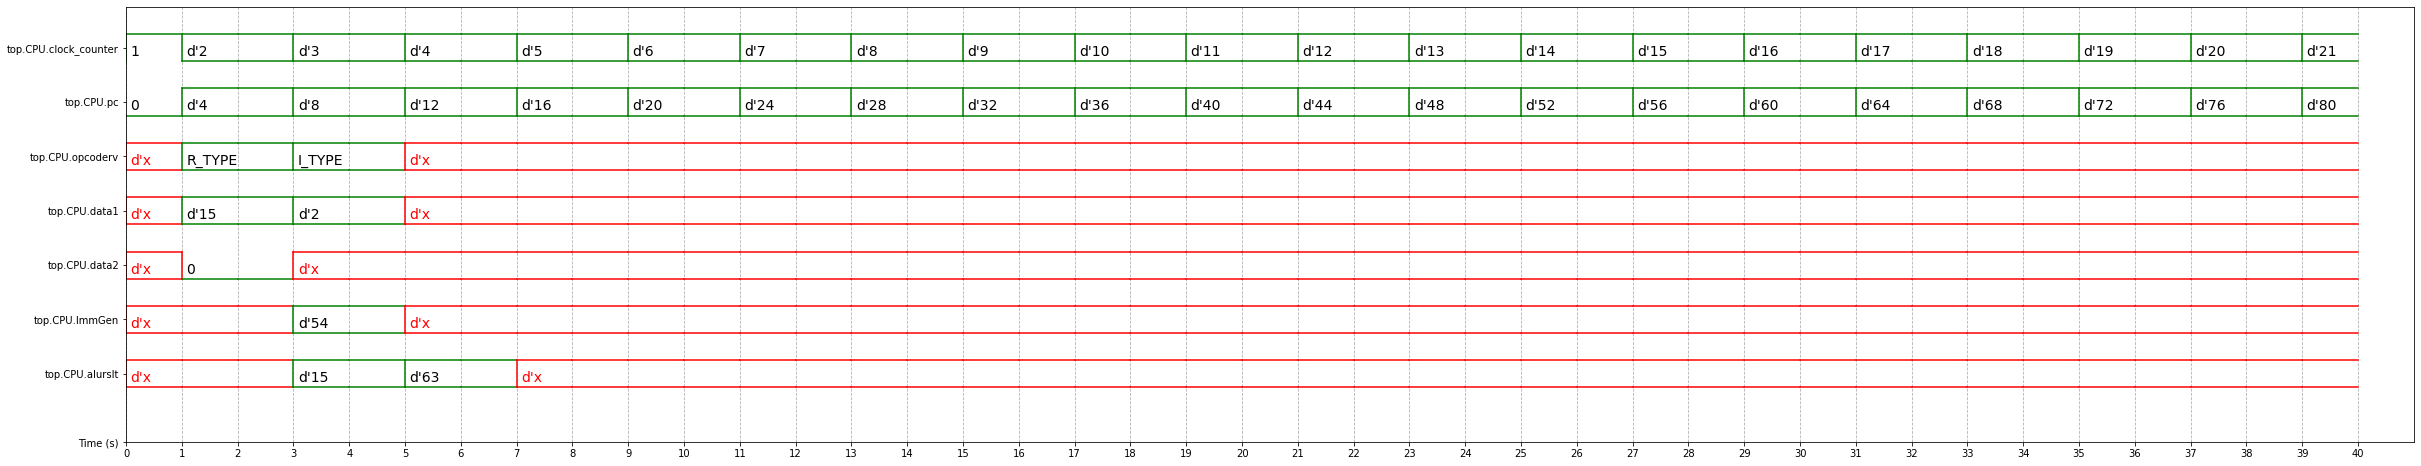

In [105]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'R_TYPE','10011':'I_TYPE'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter', 'top.CPU.pc', 'top.CPU.opcoderv,r[1]' , 'top.CPU.data1', 'top.CPU.data2','top.CPU.ImmGen','top.CPU.alurslt']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


O top.CPU.alurslt nos permite observar que os valores estão sendo computados corretamente, pois após a instrução o valor 63 foi obtido com sucesso.

##### Teste 2

Nesse teste, iremos realizar a operação de ORI entre os valores 213 e 434. O valor 213 será armazenado no registrador x2 e o valor 434 será o imediato no ORI.

O resultado esperado para essa operação é 503


In [55]:
%%writefile simple.s
addi x2,x0,213
ori x3,x2,434

Overwriting simple.s


In [56]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 2


In [57]:
!cat simple/txt/simple.txt

00001101010100000000000100010011
00011011001000010110000110010011


In [58]:
!cat im_data.txt

d500113
1b216193


In [59]:
%%verilog
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



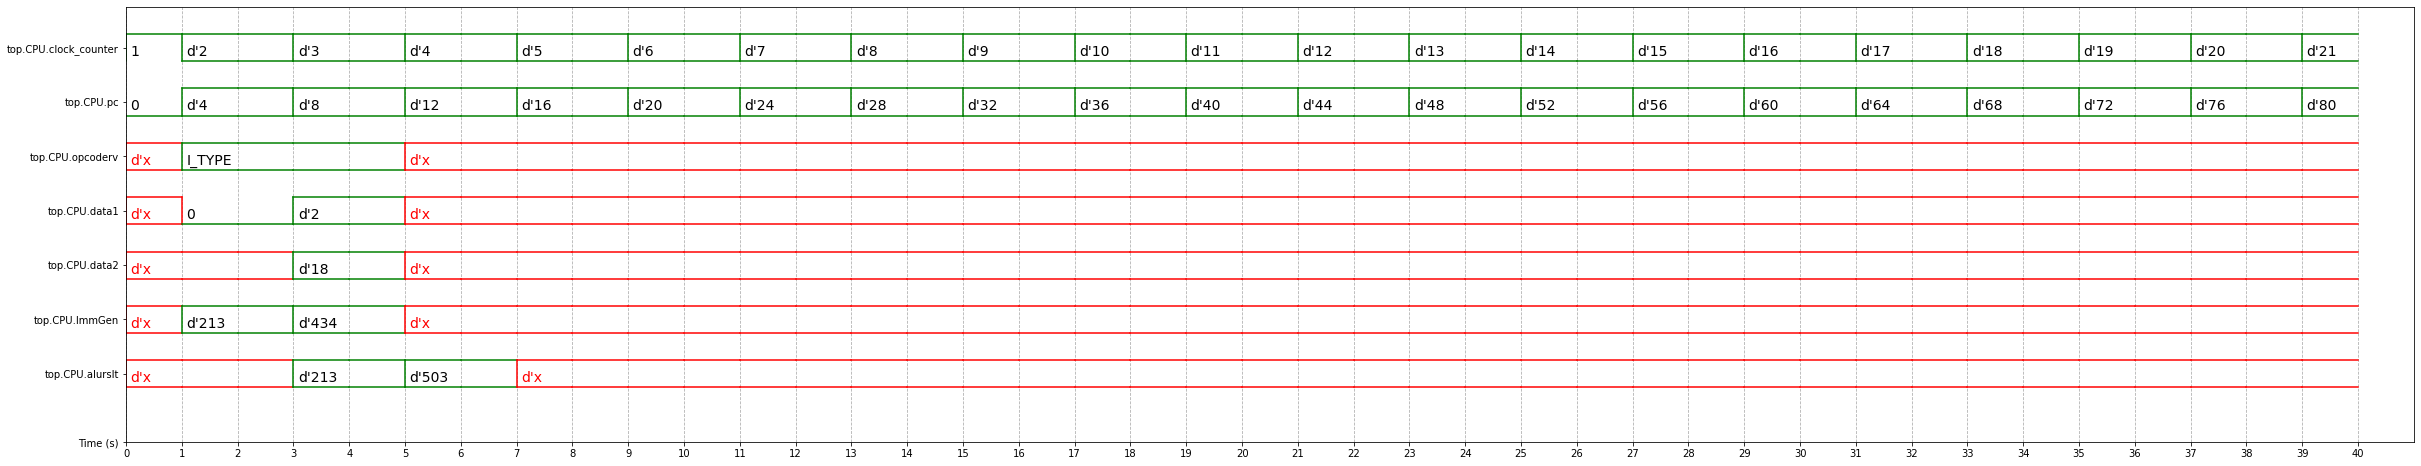

In [60]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'R_TYPE','10011':'I_TYPE'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter', 'top.CPU.pc', 'top.CPU.opcoderv,r[1]' , 'top.CPU.data1', 'top.CPU.data2','top.CPU.ImmGen','top.CPU.alurslt']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


Novamente, podemos observar que o valor correto está sendo calculado. Assim, concluimos que a operação de ORI foi implementada corretamente.

### Problema 2:  SLLI -Shift Left Logical Immediate


#### Testes

##### Teste 1
Nesse exemplo, iremos shiftar o valor 8 armazenado em x2 em três bits para a direita. Isso equivale a multiplicar o valor por 8, ou seja, o resultado esperado é 64.

In [61]:
%%writefile simple.s
addi x2,x0,8
slli x3,x2,3

Overwriting simple.s


In [62]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 2


In [63]:
!cat simple/txt/simple.txt

00000000100000000000000100010011
00000000001100010001000110010011


In [64]:
!cat im_data.txt

800113
311193


In [65]:
%%verilog
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



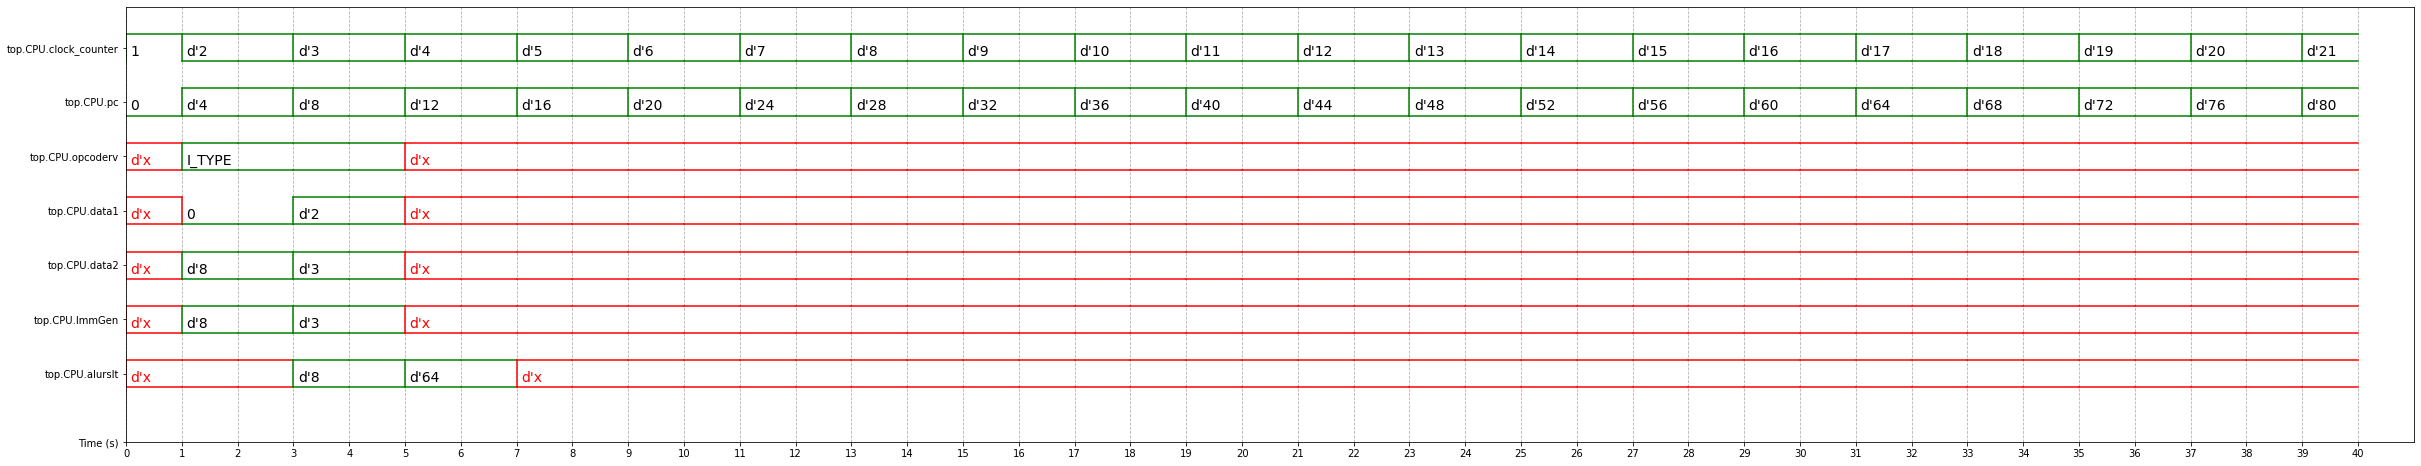

In [66]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'R_TYPE','10011':'I_TYPE'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter', 'top.CPU.pc', 'top.CPU.opcoderv,r[1]' , 'top.CPU.data1', 'top.CPU.data2','top.CPU.ImmGen','top.CPU.alurslt']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


O valor da alu result no tempo de clock 4 nos mostra o resultado de 64 esperado.

##### Teste 2

Nesse teste, iremos shiftar o valor 234 em 4 bits para a direita, o que equivale a multiplicar 234 por 16, que é igual a 3744.

In [67]:
%%writefile simple.s
addi x2,x0,234
slli x3,x2,4

Overwriting simple.s


In [68]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 2


In [69]:
!cat simple/txt/simple.txt

00001110101000000000000100010011
00000000010000010001000110010011


In [70]:
!cat im_data.txt

ea00113
411193


In [71]:
%%verilog
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



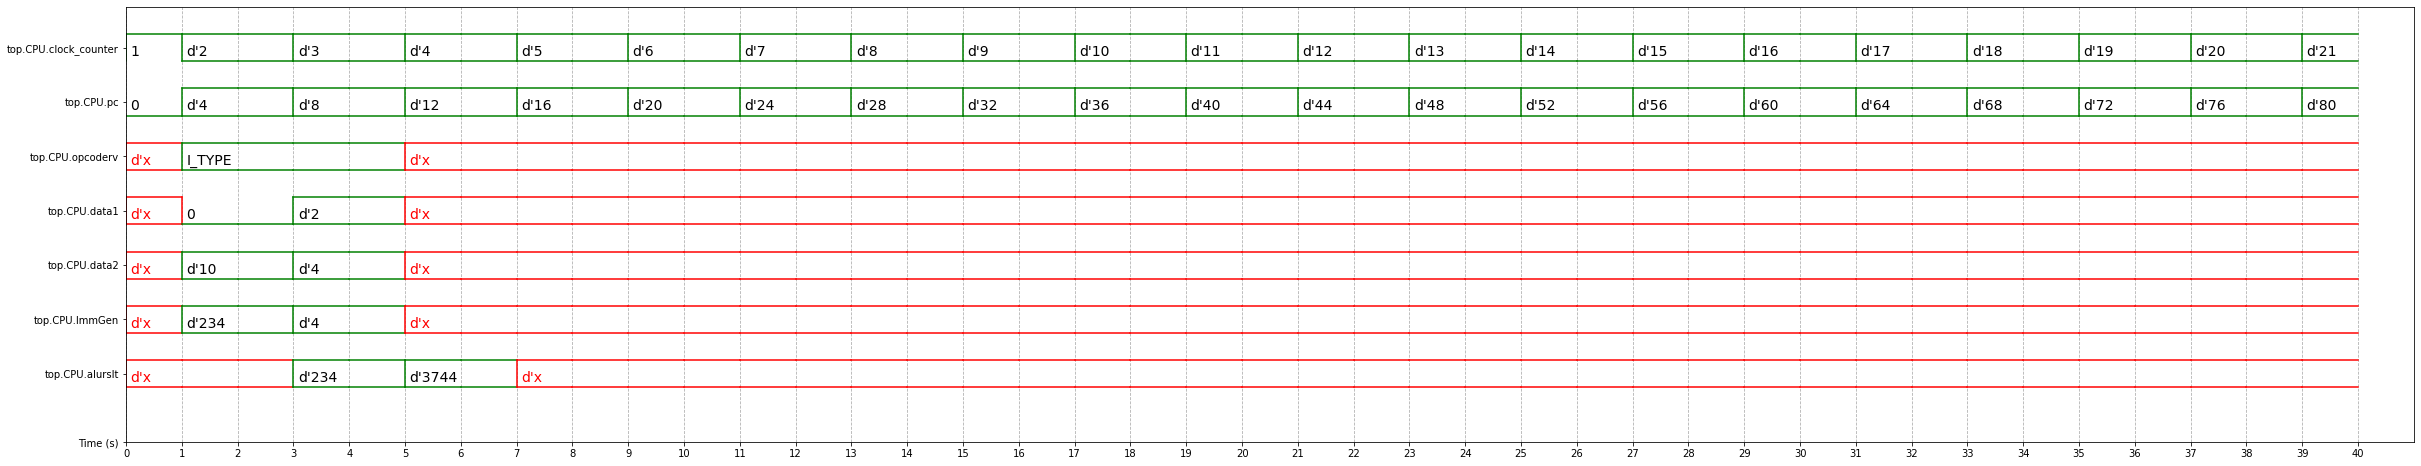

In [72]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'R_TYPE','10011':'I_TYPE'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter', 'top.CPU.pc', 'top.CPU.opcoderv,r[1]' , 'top.CPU.data1', 'top.CPU.data2','top.CPU.ImmGen','top.CPU.alurslt']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


O valor da alu result no tempo de clock 4 nos mostra o resultado de 3744 esperado. Os testes nos permitem concluir que a operação foi implementada com sucesso.

### Problema 3:  BLT -Branch on Less Than



#### Teste
**RESSALTAMOS QUE O ASSEMBLER RISCV IMPORTADO NESSE NOTEBOOK ESTÁ COM O PROBLEMA DESTACADO NA MONITORIA, I.E., O IMEDIATO DE QUALQUER BRANCH VALE 4054!**

Nesse exemplo, iremos tentar realizar um BLT com um offset de 4054, após realizar algumas operações.

Primeiramente mostraremos que o BLT não ocorre quando rs1 >= rs2, através da primeira instrução. Após isso, realizamos uma série de instruções e então checaremos se o registrador x4, que contém o valor 5, é menor que o valor em x3, que contém o valor 10. O BLT então incrementa o PC em 4054.


In [73]:
%%writefile simple.s
blt x0,x0,4054
addi x3,x0,10
addi x2,x0,15
sub x4,x2,x3
blt x4,x3,4054

Overwriting simple.s


In [74]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 5


In [75]:
!cat simple/txt/simple.txt

01111100000000000100101111100011
00000000101000000000000110010011
00000000111100000000000100010011
01000000001100010000001000110011
01111100001100100100101111100011


In [76]:
!cat im_data.txt

7c004be3
a00193
f00113
40310233
7c324be3


In [77]:
%%verilog
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



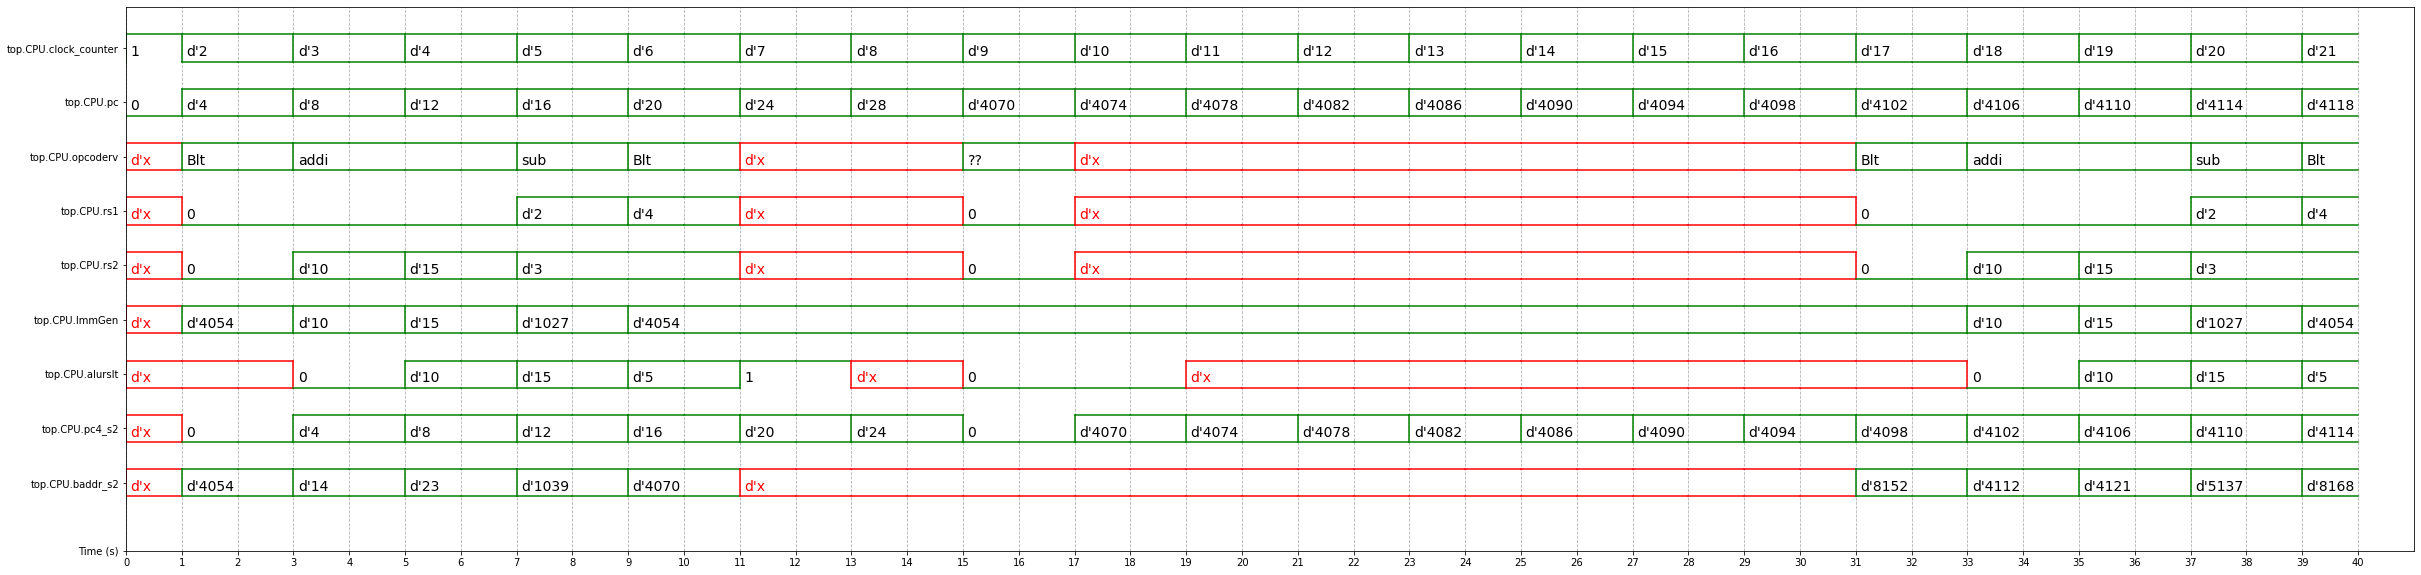

In [79]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'sub','10011':'addi', '1100011':'Blt'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter', 'top.CPU.pc', 'top.CPU.opcoderv,r[1]' , 'top.CPU.rs1', 'top.CPU.rs2','top.CPU.ImmGen','top.CPU.alurslt', 'top.CPU.pc4_s2','top.CPU.baddr_s2' ]
time_begin = 0
time_end = 40
base = 'dec' # bin, dec, dec2, hex, octal


O gráfico de ondas ilustra o sucesso da operação. Inicialmente, se tenta fazer um BLT ao comparar x0 com x0, e o alurslt nesse caso é 0, ou seja, o branch não será realizado. Ao fim, se compara x4 com x3 e se obtem que alurslt é igual a 1, ou seja, como x4 é de fato menor que x3, o branch será realizado. Observa-se no clock_counter 9 que o PC foi de fato alterado com o offset especificado(4054 + 16 = 4070). Esse exemplo mostra que a operação BLT está funcionando corretamente.